## Preprocessing - Reweighing -  Compas Model
- for 'sex' and 'race'

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.insert(0, project_root)

import pandas as pd
import matplotlib.pyplot as plt
from src.data_loading import load_compas_race, load_compas_sex
from src.modeling import reweighing_train_and_predict
from src.metrics import compute_metrics, compare_viz_metrics_2x3, save_agg_metrics, save_raw_metrics
from sklearn.model_selection import StratifiedShuffleSplit

/opt/anaconda3/lib/python3.11/site-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/opt/anaconda3/lib/python3.11/site-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_ndcg = vmap(vect_normalized_di

In [2]:
dataset_name = 'compas'
mitigation_name   = 'reweighing'
pipeline_stage    = 'preprocessing'   
out_dir_plots    = '../../reports/plots_compas'

In [3]:
baseline_race_agg = pd.read_csv('../../reports/baseline_agg/compas_race_metrics_agg.csv', index_col=0)
baseline_sex_agg = pd.read_csv('../../reports/baseline_agg/compas_sex_metrics_agg.csv', index_col=0)

---------------------------------


## reweighing, sex

In [4]:
# 1) Retrieve data
protected = 'sex'
privileged_value   = 0.0
unprivileged_value = 1.0

cd, df = load_compas_sex()
feature_cols = [c for c in df.columns if c not in ('label','sex')]

# 2) Set up 25-fold stratified CV
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)
results = []

for train_idx, test_idx in sss.split(df, df['label']):
    test_df, y_test, y_pred = reweighing_train_and_predict(
        cd, df,
        train_idx, test_idx,
        protected, privileged_value, unprivileged_value
    )
    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)

# 3) Aggregate results
compas_sex_metrics = pd.DataFrame(results)
compas_sex_metrics_agg = compas_sex_metrics.agg(['mean', 'std'])
print(compas_sex_metrics_agg)

      accuracy  f1_score       SPD        DI       EOD       AOD
mean  0.668080  0.591349 -0.023823  0.937973 -0.004748  0.010818
std   0.010156  0.013591  0.042458  0.114255  0.060376  0.042528


/var/folders/pr/f4jl4tln3yn9fd_1yjrwwkp40000gn/T/ipykernel_63868/1084008501.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


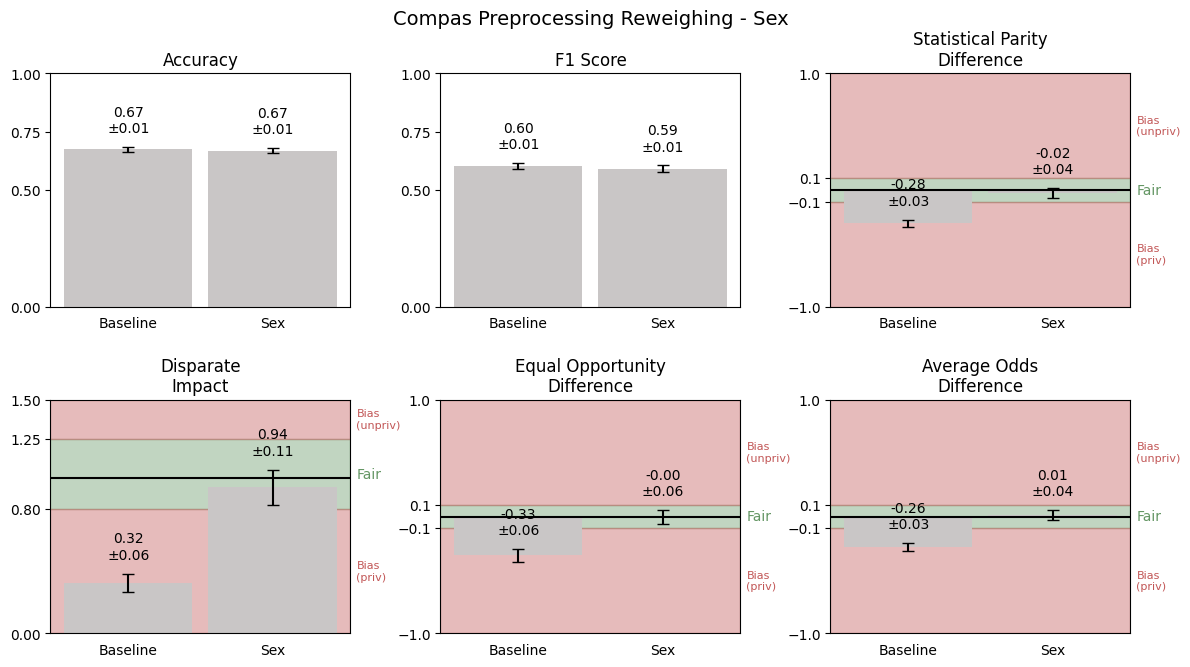

In [5]:
plot_title = 'Compas Preprocessing Reweighing - Sex'
fig = compare_viz_metrics_2x3(baseline_sex_agg, compas_sex_metrics_agg, 'Baseline', 'Sex', plot_title)
fname    = plot_title.replace(' ', '_').replace('(', '').replace(')', '')
out_path = os.path.join(out_dir_plots, f'{fname}.png')
fig.savefig(out_path)
fig.show()

## reweighing, race

In [6]:
# 1) Retrieve data
protected = 'race'
privileged_value   = 0.0
unprivileged_value = 1.0

cd, df = load_compas_race()
feature_cols = [c for c in df.columns if c not in ('label','race')]

# 2) Set up 25-fold stratified CV
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)
results = []

for train_idx, test_idx in sss.split(df, df['label']):
    test_df, y_test, y_pred = reweighing_train_and_predict(
        cd, df,
        train_idx, test_idx,
        protected, privileged_value, unprivileged_value
    )
    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)

# 3) Aggregate results
compas_race_metrics = pd.DataFrame(results)
compas_race_metrics_agg = compas_race_metrics.agg(['mean', 'std'])
print(compas_race_metrics_agg)

      accuracy  f1_score       SPD        DI       EOD       AOD
mean  0.662647  0.582125  0.025924  1.078250  0.029864  0.049803
std   0.012205  0.014836  0.035788  0.110244  0.038988  0.032704


/var/folders/pr/f4jl4tln3yn9fd_1yjrwwkp40000gn/T/ipykernel_63868/555537112.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


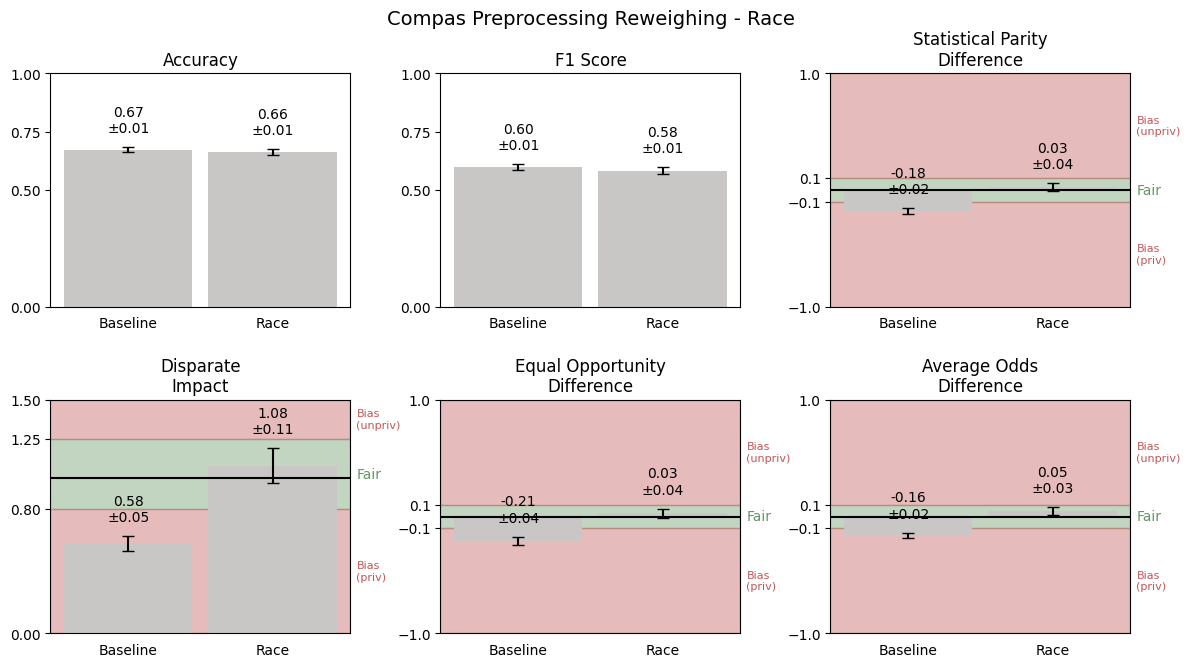

In [7]:
plot_title = 'Compas Preprocessing Reweighing - Race'
fig = compare_viz_metrics_2x3(baseline_race_agg, compas_race_metrics_agg, 'Baseline', 'Race', plot_title) 
fname    = plot_title.replace(' ', '_').replace('(', '').replace(')', '')
out_path = os.path.join(out_dir_plots, f'{fname}.png')
fig.savefig(out_path)
fig.show()

----------------------------------

In [8]:
# 1) Save the aggregated metrics 
save_agg_metrics(
    dataset_name      = dataset_name,
    mitigation_name   = mitigation_name,
    race_agg_df       = compas_race_metrics_agg,
    sex_agg_df        = compas_sex_metrics_agg,
    pipeline_stage    = pipeline_stage   
)

# 2) Save the raw metrics
save_raw_metrics(
    dataset_name      = dataset_name,
    mitigation_name   = mitigation_name,
    race_raw_df       = compas_race_metrics,
    sex_raw_df        = compas_sex_metrics,
    pipeline_stage    = pipeline_stage
)
